In [ ]:
!unzip /content/drive/MyDrive/Datasets/cranfield.zip

In [ ]:
!pip install rank_bm25

In [ ]:
#@title Python libraries used in the project
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import numpy as np
from nltk.tokenize import word_tokenize
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import json
from rank_bm25 import BM25Okapi
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#@title Code for data preprocessing
def data_preprocess(doc):
  tokens = word_tokenize(doc)
  # convert to lower case 
  tokens = [w.lower() for w in tokens]
  # remove punctuation from each word
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic
  words = [word for word in stripped if word.isalpha()]
  # filter out stop words
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  # stemming of words
  porter = PorterStemmer()
  stemmed = [porter.stem(word) for word in words]
  return stemmed

In [ ]:
#@title Code for evaluation
import math
import os

# Add your import statements here
from collections import defaultdict



class Evaluation():
    def __init__(self):
      self.qr=None #This dictionary holds the list of relevant documents for a particular query
    def build_qr(self,q_rels):
      #This function populates the self.qr dictionary which has relevant document lists as values and
      #query ids as keys of the dictionary
      qr = defaultdict(list)
      for dc in q_rels:
        qr[int(dc['query_num'])].append(int(dc['id']))
      self.qr=qr
    def get_docid(self,query_id,qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
      return doc_id

    def get_rel_score(self, query_id,element, qrels):
      result = list(filter(lambda query: query['query_num'] == str(query_id), qrels))
      doc_id = []
      rel_score = []
      for d in result:
        for k, v in d.items():
          if k == "id":
            doc_id.append(v)
          if k == "position":
            # Measuring the relevance score in a scale of 0-3 where integer with higher value has greater relevance
            rel_score.append(4-int(v))

      relavant_score = rel_score[doc_id.index(element)]
      return relavant_score

    def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The precision value as a number between 0 and 1
      """

      precision = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment precision count by 1.
          if str(element) in true_doc_IDs:
            precision = precision + 1
        count = count + 1
      if k== 0:
        precision = 1
      else:
        # Dividing precision by number of documents retrieved at rank 'k'
        precision = precision / k

      return precision


    def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of precision of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean precision value as a number between 0 and 1
      """

      meanPrecision = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryPrecision(l, query_ids[n], doc_id, k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanPrecision = 1
      else:
        # Finding the average of all precision values corresponding to different queries
        meanPrecision = sum / len(doc_IDs_ordered)
      return meanPrecision


    def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The recall value as a number between 0 and 1
      """

      recall = 0

      #Fill in code here
      count = 1
      for element in query_doc_IDs_ordered:
        # Find the number of relevant documents in top k results
        if count <= k:
          # if the document is present in the relevant document list then increment recall count by 1.
          if str(element) in true_doc_IDs:
            recall = recall + 1
        count = count + 1
      if len(true_doc_IDs) == 0:
        recall = 1
      else:
        # Dividing recall by number of relevant documents
        recall = recall / len(true_doc_IDs)

      return recall


    def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of recall of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean recall value as a number between 0 and 1
      """

      meanRecall = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryRecall(l,query_ids[n],doc_id,k)
        n = n + 1
      if len(doc_IDs_ordered) == 0:
        meanRecall = 1
      else:
        # Finding the average of all recall values corresponding to different queries
        meanRecall = sum / len(doc_IDs_ordered)
      return meanRecall

    def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The fscore value as a number between 0 and 1
      """

      fscore = -1

      #Fill in code here
      precision = self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      recall = self.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
      # This will happen when there are no relevant documents in top k results
      if precision + recall == 0:
        fscore = 0
      else:
        fscore = (2 * precision * recall) / (precision + recall)

      return fscore

    def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of fscore of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean fscore value as a number between 0 and 1
      """

      meanFscore = -1

      # Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids):break
        doc_id = self.get_docid(query_ids[n], qrels)
        sum = sum + self.queryFscore(l, query_ids[n], doc_id, k)
        n = n + 1
      # Finding the average of all fscore values corresponding to different queries
      meanFscore = sum / len(doc_IDs_ordered)
      return meanFscore


    def queryNDCG(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of nDCG of the Information Retrieval System
      at given value of k for a single query

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of IDs of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The nDCG value as a number between 0 and 1
      """

      nDCG = -1

      #Fill in code here
      DCG = 0
      IDCG = 0
      #path=os.path.join(os.getcwd(),"cranfield","cran_qrels.json")
      qrels = json.load(open('/content/cranfield/cran_qrels.json', 'r'))[:]
      count = 1
      for element in query_doc_IDs_ordered:
        if count <= k:
          if str(element) in true_doc_IDs:
            DCG = DCG + (self.get_rel_score(query_id, str(element), qrels) / math.log2(query_doc_IDs_ordered.index(element) + 2))
          count = count + 1
      count = 1
      for element in true_doc_IDs:
        if count <= k:
          IDCG = IDCG + (self.get_rel_score(query_id,element,qrels) / math.log2(count + 1))
          count = count + 1
      # When there are no documents in the ideally relevant to the query then there are no documents to display.
      # Thus the relevance score is 1.
      if IDCG == 0:
        IDCG = 1
      nDCG = DCG / IDCG
      return nDCG


    def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
      """
      Computation of nDCG of the Information Retrieval System
      at a given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries for which the documents are ordered
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The mean nDCG value as a number between 0 and 1
      """

      meanNDCG = -1

      #Fill in code here
      n = 0
      sum = 0
      for l in doc_IDs_ordered:
        if n==len(query_ids): break
        true_doc_IDs = self.get_docid(query_ids[n], qrels)
        nDCG=self.queryNDCG(l, query_ids[n], true_doc_IDs, k)
        sum = sum + nDCG
        n = n + 1
      # Finding the average of all nDCG values corresponding to different queries
      meanNDCG = sum/len(doc_IDs_ordered)
      return meanNDCG


    def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
      """
      Computation of average precision of the Information Retrieval System
      at a given value of k for a single query (the average of precision@i
      values for i such that the ith document is truly relevant)

      Parameters
      ----------
      arg1 : list
        A list of integers denoting the IDs of documents in
        their predicted order of relevance to a query
      arg2 : int
        The ID of the query in question
      arg3 : list
        The list of documents relevant to the query (ground truth)
      arg4 : int
        The k value

      Returns
      -------
      float
        The average precision value as a number between 0 and 1
      """

      avgPrecision = -1

      #Fill in code here
      pdl=query_doc_IDs_ordered
      rdl=true_doc_IDs
      for j in range(len(pdl)):
        if pdl[j] in rdl:
          pdl[j] = 1
        else:
          pdl[j] = 0
      ap = 0
      for j in range(len(pdl)):
        ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
      ap /= len(pdl)
      avgPrecision=ap
      return avgPrecision


    def meanAveragePrecision(self, doc_IDs_ordered, query_ids, q_rels, k):
      """
      Computation of MAP of the Information Retrieval System
      at given value of k, averaged over all the queries

      Parameters
      ----------
      arg1 : list
        A list of lists of integers where the ith sub-list is a list of IDs
        of documents in their predicted order of relevance to the ith query
      arg2 : list
        A list of IDs of the queries
      arg3 : list
        A list of dictionaries containing document-relevance
        judgements - Refer cran_qrels.json for the structure of each
        dictionary
      arg4 : int
        The k value

      Returns
      -------
      float
        The MAP value as a number between 0 and 1
      """

      meanAveragePrecision = -1

      #Fill in code here
      MAP = 0
      # preprocess q_rels
      self.build_qr(q_rels)
      qr = self.qr

      for i in range(len(query_ids)):
        # print(len(doc_IDs_ordered_all),len(query_ids))
        pdl = doc_IDs_ordered[i][:k]
        rdl = qr[int(query_ids[i])]
        #print(pdl[:10], rdl)
        for j in range(len(pdl)):
          if pdl[j] in rdl:
            pdl[j] = 1
          else:
            pdl[j] = 0
        ap = 0
        for j in range(len(pdl)):
          ap += (sum(pdl[:(j + 1)]) * 1.0 / (j + 1))
        ap /= len(pdl)
        MAP += ap
      MAP /= len(query_ids)
      meanAveragePrecision=MAP


      return meanAveragePrecision



In [ ]:
#@title Function for old method (Tfidf)
def train_old(k):
  #without SVD
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  #print(len(dids),len(qids))
  qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.6)
  dvecs1=vectorizer.fit_transform(docs).todense()
  qvecs1=vectorizer.transform(qrs).todense()
  #print(dvecs1.shape,qvecs1.shape)
  B=sklearn.metrics.pairwise.cosine_similarity(qvecs1,dvecs1)

  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(B[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=dids[y]
      j+=1
  pdl=pred_ids.tolist()

  results1=[]
  for i in range(20):
    s=i*10
    e=s+10
    results1.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using old method- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('Tfidf.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results1:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results1,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)

  

In [ ]:
#@title Function for using LSA
def train_new(k):
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body']+' '+item['title'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  #print(len(dids),len(qids))
  #k=5
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9,ngram_range=(1,2))
  svd_model = TruncatedSVD(n_components=500,         
                          algorithm='randomized',
                          n_iter=10)
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  dvecs=svd_transformer.fit_transform(docs)
  from scipy.sparse import csr_matrix
  #qvecs_qe=np.dot(vectorizer.transform(qrs).todense(),wsim)
  #qvecs=np.dot(qvecs_qe,svd_model.components_.T)
  qvecs=svd_transformer.transform(qrs)
  #print(qvecs.shape)
  A=sklearn.metrics.pairwise.cosine_similarity(qvecs,dvecs)
  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=dids[y]
      j+=1
  pdl=pred_ids.tolist()
  qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  results=[]
  for i in range(20):
    s=i*10
    e=s+10
    results.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using new method using LSA- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('LSA.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)


In [ ]:
#@title Using both bm25 and LSA
def data_preprocess1(docs):
  doc_list=[]
  for every_doc in docs:
    tokens = word_tokenize(every_doc)
    # convert to lower case 
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokens]
    doc_list.append(stemmed)
  return doc_list

def get_wsim():
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body']+' '+item['title'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  #print(len(dids),len(qids))
  #k=5
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9)
  svd_model = TruncatedSVD(n_components=325,         
                          algorithm='randomized',
                          n_iter=10)
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  dvecs=svd_transformer.fit_transform(docs)
  wsim=sklearn.metrics.pairwise.cosine_similarity(svd_model.components_.T,svd_model.components_.T)
  return wsim
def train_mixed(k,k1=1,k2=1):
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body']+' '+item['title'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  tot_query = len(qids)
  pred_ids=np.zeros((tot_query,k),dtype=int)
  tokenized_corpus = data_preprocess1(docs)
  tokenized_query = data_preprocess1(qrs)
  bm25 = BM25Okapi(tokenized_corpus)
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9,ngram_range=(1,2))
  svd_model = TruncatedSVD(n_components=500,         
                          algorithm='randomized',
                          n_iter=10)
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  dvecs=svd_transformer.fit_transform(docs)
  wsim=get_wsim()
  v=vectorizer.get_feature_names()
  
  stop_words = set(stopwords.words('english')) 
  import random
  for i in range(len(qrs)):
    new_qr=qrs[i]
    tkns=nltk.word_tokenize(qrs[i])
    random.shuffle(tkns)
    for x in tkns :
      k2=k2-1
      if k2<=0: break
      if x not in stop_words:
        try:
          new_qr+=(' '+' '.join(getsyn(x,k1+1,v,wsim)[1:]))
        except Exception:
          pass
    #if i<2:
      #print('old-',qrs[i])
      #print('new-',new_qr)
      #print('\n\n')
    qrs[i]=new_qr
  from scipy.sparse import csr_matrix
  #qvecs_qe=np.dot(vectorizer.transform(qrs).todense(),wsim)
  #qvecs=np.dot(qvecs_qe,svd_model.components_.T)
  qvecs=svd_transformer.transform(qrs)
  #print(qvecs.shape)
  A=sklearn.metrics.pairwise.cosine_similarity(qvecs,dvecs)
  A=(A-A.min(axis=1).reshape(-1,1))/A.max(axis=1).reshape(-1,1)
  pred_ids=np.zeros((255,k),dtype=int)
  alpha=90.0/(90+77.0)
  for i in range(0,tot_query):
    doc_scores = bm25.get_scores(tokenized_query[i])
    doc_scores = (doc_scores-doc_scores.min(axis=0))/doc_scores.max(axis=0)
    A[i]=alpha*A[i]+(1-alpha)*doc_scores.reshape(1,-1)
  for i in range(0,225):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=dids[y]
      j+=1
  pdl=pred_ids.tolist()
  qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  results=[]
  for i in range(20):
    s=i*10
    e=s+10
    results.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using new method with bm25 and LSA- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('LSA+BM25.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)

In [ ]:
#@title Function for LSA with Query expansion
def getsyn(x,k,v,wsim):
  if x in v:
    i= v.index(x)
    y = np.argsort(wsim[i]).T[::-1][:k]
    ans=[v[i] for i in y]
    return ans
  else:
    return []

def train_new_qe(k,k1,k2):
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body']+' '+item['title'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  #print(len(dids),len(qids))
  #k=5
  vectorizer = TfidfVectorizer(tokenizer=data_preprocess,stop_words=None, 
                             use_idf=True, 
                             smooth_idf=True,max_df=0.9)
  svd_model = TruncatedSVD(n_components=325,         
                          algorithm='randomized',
                          n_iter=10)
  svd_transformer = Pipeline([('tfidf', vectorizer), 
                              ('svd', svd_model)])
  dvecs=svd_transformer.fit_transform(docs)
  wsim=sklearn.metrics.pairwise.cosine_similarity(svd_model.components_.T,svd_model.components_.T)
  v=vectorizer.get_feature_names()
  
  stop_words = set(stopwords.words('english')) 
  import random
  for i in range(len(qrs)):
    new_qr=qrs[i]
    tkns=nltk.word_tokenize(qrs[i])
    random.shuffle(tkns)
    for x in tkns :
      k2=k2-1
      if k2<=0: break
      if x not in stop_words:
        try:
          new_qr+=(' '+' '.join(getsyn(x,k1+1,v,wsim)[1:]))
        except Exception:
          pass
    #if i<2:
      #print('old-',qrs[i])
      #print('new-',new_qr)
      #print('\n\n')
    qrs[i]=new_qr
  from scipy.sparse import csr_matrix
  #qvecs_qe=np.dot(vectorizer.transform(qrs).todense(),wsim)
  #qvecs=np.dot(qvecs_qe,svd_model.components_.T)
  qvecs=svd_transformer.transform(qrs)
  #print(qvecs.shape)
  A=sklearn.metrics.pairwise.cosine_similarity(qvecs,dvecs)
  pred_ids=np.zeros((255,k),dtype=int)
  for i in range(0,225):
    x=np.argsort(A[i]).T[::-1][:k]
    j=0
    for y in x:
      pred_ids[i][j]=dids[y]
      j+=1
  pdl=pred_ids.tolist()
  qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  results=[]
  for i in range(20):
    s=i*10
    e=s+10
    results.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using new method with query expansion- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('LSA+QE.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)

In [ ]:
#@title BM25 code
def train_bm25(k):
  import json
  dj = json.load(open('/content/cranfield/cran_docs.json', 'r'))
  docs,dids=[item['body']+' '+item['title'] for item in dj],[item['id'] for item in dj]
  qj = json.load(open('/content/cranfield/cran_queries.json', 'r'))
  qrs,qids=[item['query'] for item in qj],[item['query number'] for item in qj]
  tot_query = len(qids)
  pred_ids=np.zeros((tot_query,k),dtype=int)
  tokenized_corpus = data_preprocess1(docs)
  tokenized_query = data_preprocess1(qrs)
  bm25 = BM25Okapi(tokenized_corpus)

  for i in range(0,tot_query):
    doc_scores = bm25.get_scores(tokenized_query[i])
    top_n = np.argsort(doc_scores)[::-1][:k]
    index = 0
    for j in top_n:
      pred_ids[i][index]=dids[j]
      index = index + 1
  
  pdl=pred_ids.tolist()
  pdl
  qrels=json.load(open('/content/cranfield/cran_qrels.json', 'r'))
  eval=Evaluation()
  results=[]
  for i in range(20):
    s=i*10
    e=s+10
    results.append([eval.meanAveragePrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanNDCG(pdl[s:e],qids[s:e],qrels,k),eval.meanPrecision(pdl[s:e],qids[s:e],qrels,k),eval.meanRecall(pdl[s:e],qids[s:e],qrels,k),eval.meanFscore(pdl[s:e],qids[s:e],qrels,k)])
  print('Using new method with bm25- k: '+str(k)+' nDCG: '+str(eval.meanNDCG(pdl,qids,qrels,k)))
  if k==3:
    rf=open('BM25.csv','w')
    rf.write('MAP,NDCG,MeanPrecision,MeanRecall,MeanFscore\n')
    for x in results:
      rf.write(str(x[0])+','+str(x[1])+','+str(x[2])+','+str(x[3])+','+str(x[4])+'\n')
    rf.close()
  return results,eval.meanNDCG(pdl,qids,qrels,k),eval.meanAveragePrecision(pdl,qids,qrels,k),eval.meanRecall(pdl,qids,qrels,k),eval.meanFscore(pdl,qids,qrels,k)



In [ ]:
#@title Statistcal Hypothesis testing code
import numpy as np
from statistics import variance
from scipy import stats

def test(x,y,a):
  print('x-new method in this test, y- old method(Tfidf)')
  #null hypothesis: mean of x is less than or equal to mean of y
  #alternate hypothesis: mean of x is greater than mean of y
  print('null hypothesis: mean of x is less than or equal to mean of y')
  print('alternate hypothesis: mean of x is greater than mean of y')
  n=len(x)
  m=n
  df=n+m-2
  x_ , y_ = sum(x)/n, sum(y)/n
  sx ,sy =variance(x),variance(y)
  sp = ((n-1)*sx+(m-1)*sy)/(n+m-2)
  ts = (x_ - y_)/(sp*(1/m+1/n))**0.5
  z_a=stats.t.ppf(1-a,df)
  print('x_:'+str(x_)+' y_:'+str(y_)+' sx :'+str(sx)+' sy: '+str(sy)+' sp: '+str(sp))
  print('Test statistic: ',ts)
  print('t-alpha: ',z_a)
  print('p-value: ',1-stats.t.cdf(ts,df))
  print('alpha: ',a)
  if ts>z_a:
    print("Conclusion: mean of x is greater than mean of y (new method is better than old method)")
  else:
    print("Conclusion: No evidence for proving new method is better")

In [ ]:
r5 = [train_mixed(i) for i in range(1,8)]
r1 = [train_new(i) for i in range(1,8)]
r2 = [train_old(i) for i in range(1,8)]
r3 = [train_new_qe(i,1,3) for i in range(1,8)]
r4 = [train_bm25(i) for i in range(1,8)]


Using new method with bm25 and LSA- k: 1 nDCG: 0.8352941176470589
Using new method with bm25 and LSA- k: 2 nDCG: 0.733098892776449
Using new method with bm25 and LSA- k: 3 nDCG: 0.6424681779562839
Using new method with bm25 and LSA- k: 4 nDCG: 0.6238657974771331
Using new method with bm25 and LSA- k: 5 nDCG: 0.6145870774249844
Using new method with bm25 and LSA- k: 6 nDCG: 0.5931410706569323
Using new method with bm25 and LSA- k: 7 nDCG: 0.5855266627200276
Using new method using LSA- k: 1 nDCG: 0.7620915032679739
Using new method using LSA- k: 2 nDCG: 0.6839102072054672
Using new method using LSA- k: 3 nDCG: 0.6004501053170676
Using new method using LSA- k: 4 nDCG: 0.5856314926883289
Using new method using LSA- k: 5 nDCG: 0.5743607892974689
Using new method using LSA- k: 6 nDCG: 0.5613509143251078
Using new method using LSA- k: 7 nDCG: 0.554892927444243
Using old method- k: 1 nDCG: 0.7379084967320262
Using old method- k: 2 nDCG: 0.6346383320523373
Using old method- k: 3 nDCG: 0.5722315

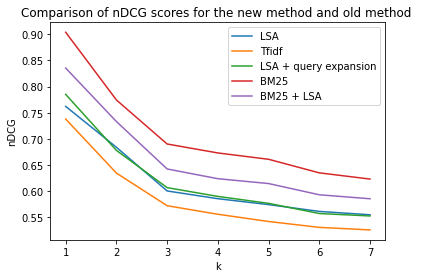

In [ ]:
#@title nDCG comparison visualization
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[1] for w in r1], label = "LSA")
plt.plot([i for i in range(1,8) ], [w[1] for w in r2], label = "Tfidf")
plt.plot([i for i in range(1,8) ], [w[1] for w in r3], label = "LSA + query expansion")
plt.plot([i for i in range(1,8) ], [w[1] for w in r4], label = "BM25")
plt.plot([i for i in range(1,8) ], [w[1] for w in r5], label = "BM25 + LSA")
plt.xlabel('k')
plt.ylabel('nDCG')
plt.title('Comparison of nDCG scores for the new method and old method ')
plt.legend()
plt.show()


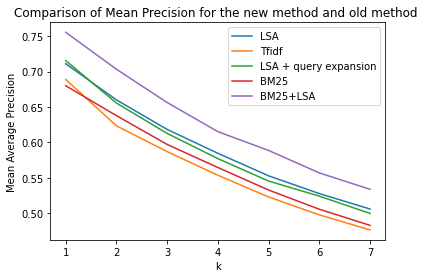

In [ ]:
#@title Mean Precision comparison visualization
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[2] for w in r1], label = "LSA")
plt.plot([i for i in range(1,8) ], [w[2] for w in r2], label = "Tfidf")
plt.plot([i for i in range(1,8) ], [w[2] for w in r3], label = "LSA + query expansion")
plt.plot([i for i in range(1,8) ], [w[2] for w in r4], label = "BM25")
plt.plot([i for i in range(1,8) ], [w[2] for w in r5], label = "BM25+LSA")
plt.xlabel('k')
plt.ylabel('Mean Precision')
plt.title('Comparison of Mean Precision for the new method and old method ')
plt.legend()
plt.show()


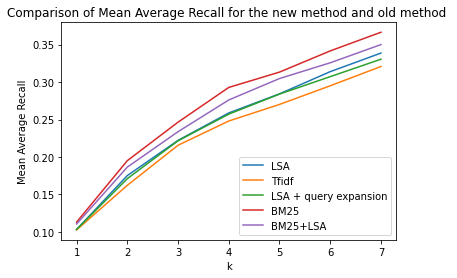

In [ ]:
#@title Mean Recall comparison
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[3] for w in r1], label = "LSA")
plt.plot([i for i in range(1,8) ], [w[3] for w in r2], label = "Tfidf")
plt.plot([i for i in range(1,8) ], [w[3] for w in r3], label = "LSA + query expansion")
plt.plot([i for i in range(1,8) ], [w[3] for w in r4], label = "BM25")
plt.plot([i for i in range(1,8) ], [w[3] for w in r5], label = "BM25+LSA")
plt.xlabel('k')
plt.ylabel('Mean Average Recall')
plt.title('Comparison of Mean Average Recall for the new method and old method ')
plt.legend()
plt.show()


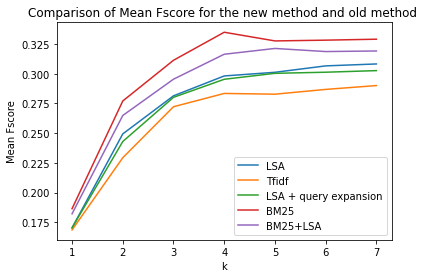

In [ ]:
#@title Mean Fscore
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,8) ], [w[4] for w in r1], label = "LSA")
plt.plot([i for i in range(1,8) ], [w[4] for w in r2], label = "Tfidf")
plt.plot([i for i in range(1,8) ], [w[4] for w in r3], label = "LSA + query expansion")
plt.plot([i for i in range(1,8) ], [w[4] for w in r4], label = "BM25")
plt.plot([i for i in range(1,8) ], [w[4] for w in r5], label = "BM25+LSA")
plt.xlabel('k')
plt.ylabel('Mean Fscore')
plt.title('Comparison of Mean Fscore for the new method and old method ')
plt.legend()
plt.show()


In [ ]:
print('Hypothesis testing for LSA vs Tfidf using nDCG metric')
d_x = [q[1] for q in r1[3][0]]
d_y = [q[1] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA vs Tfidf using nDCG metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.6704606624502769 y_:0.6347976098868618 sx :0.028921170912808627 sy: 0.026145862823338594 sp: 0.02753351686807361
Test statistic:  0.679653675553779
t-alpha:  1.3042302030325095
p-value:  0.25042165667133265
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for LSA + Query exapsnion vs Tfidf using nDCG metric')
d_x = [q[1] for q in r3[3][0]]
d_y = [q[1] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA + Query exapsnion vs Tfidf using nDCG metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.6729776544067098 y_:0.6347976098868618 sx :0.03263781343080451 sy: 0.026145862823338594 sp: 0.029391838127071555
Test statistic:  0.704243839981442
t-alpha:  1.3042302030325095
p-value:  0.24278732158788352
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25 vs Tfidf using nDCG metric')
d_x = [q[1] for q in r4[3][0]]
d_y = [q[1] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25 vs Tfidf using nDCG metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.685363678150915 y_:0.6347976098868618 sx :0.029312145269132384 sy: 0.026145862823338594 sp: 0.02772900404623549
Test statistic:  0.9602671031730882
t-alpha:  1.3042302030325095
p-value:  0.17149570572168504
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25+LSA vs Tfidf using nDCG metric')
d_x = [q[1] for q in r5[3][0]]
d_y = [q[1] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25+LSA vs Tfidf using nDCG metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.7165448283121528 y_:0.6347976098868618 sx :0.02304320187476931 sy: 0.026145862823338594 sp: 0.02459453234905395
Test statistic:  1.6483661955244953
t-alpha:  1.3042302030325095
p-value:  0.05376121681047252
alpha:  0.1
Conclusion: mean of x is greater than mean of y (new method is better than old method)


In [ ]:
print('Hypothesis testing for LSA vs Tfidf using Mean precision metric')
d_x = [q[2] for q in r1[3][0]]
d_y = [q[2] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA vs Tfidf using Mean precision metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.48125 y_:0.45625 sx :0.008873355263157894 sy: 0.01183388157894737 sp: 0.010353618421052632
Test statistic:  0.7769515386479825
t-alpha:  1.3042302030325095
p-value:  0.22099864847534723
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean Precision metric')
d_x = [q[2] for q in r3[3][0]]
d_y = [q[2] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean Precision metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.47125000000000006 y_:0.45625 sx :0.011399671052631578 sy: 0.01183388157894737 sp: 0.011616776315789475
Test statistic:  0.4400970379397516
t-alpha:  1.3042302030325095
p-value:  0.3311800052699596
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25 vs Tfidf using Mean Precision metric')
d_x = [q[2] for q in r4[3][0]]
d_y = [q[2] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25 vs Tfidf using Mean Precision metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.4699999999999999 y_:0.45625 sx :0.010894736842105261 sy: 0.01183388157894737 sp: 0.011364309210526315
Test statistic:  0.40787884160855886
t-alpha:  1.3042302030325095
p-value:  0.3428258368413517
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25+LSA vs Tfidf using Mean Precision metric')
d_x = [q[2] for q in r5[3][0]]
d_y = [q[2] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25+LSA vs Tfidf using Mean Precision metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.5050000000000001 y_:0.45625 sx :0.007276315789473684 sy: 0.01183388157894737 sp: 0.009555098684210526
Test statistic:  1.5770920106052175
t-alpha:  1.3042302030325095
p-value:  0.061531999742764465
alpha:  0.1
Conclusion: mean of x is greater than mean of y (new method is better than old method)


In [ ]:
print('Hypothesis testing for LSA vs Tfidf using Mean Recall metric')
d_x = [q[3] for q in r1[3][0]]
d_y = [q[3] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA vs Tfidf using Mean Recall metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.3028484739539253 y_:0.29228076656552826 sx :0.007272167800063336 sy: 0.008283757156909804 sp: 0.00777796247848657
Test statistic:  0.3789202870429477
t-alpha:  1.3042302030325095
p-value:  0.35342804690873764
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean Recall metric')
d_x = [q[3] for q in r3[3][0]]
d_y = [q[3] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean Recall metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.3000650288859214 y_:0.29228076656552826 sx :0.008921270487527187 sy: 0.008283757156909804 sp: 0.008602513822218496
Test statistic:  0.2654023556015073
t-alpha:  1.3042302030325095
p-value:  0.3960670336200778
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25 vs Tfidf using Mean Recall metric')
d_x = [q[3] for q in r4[3][0]]
d_y = [q[3] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25 vs Tfidf using Mean Recall metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.30188562985358114 y_:0.29228076656552826 sx :0.00808946969840244 sy: 0.008283757156909804 sp: 0.008186613427656121
Test statistic:  0.3356904961251618
t-alpha:  1.3042302030325095
p-value:  0.36947535044218993
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25+LSA vs Tfidf using Mean Recall metric')
d_x = [q[3] for q in r5[3][0]]
d_y = [q[3] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25+LSA vs Tfidf using Mean Recall metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.32196161979501225 y_:0.29228076656552826 sx :0.0066771846553886505 sy: 0.008283757156909804 sp: 0.007480470906149228
Test statistic:  1.0852053153521903
t-alpha:  1.3042302030325095
p-value:  0.1423338069714769
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for LSA vs Tfidf using Mean F-score metric')
d_x = [q[4] for q in r1[3][0]]
d_y = [q[4] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA vs Tfidf using Mean F-score metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.3464597567960757 y_:0.33100601541598923 sx :0.006771081360019376 sy: 0.008343585799317679 sp: 0.007557333579668528
Test statistic:  0.562146283585501
t-alpha:  1.3042302030325095
p-value:  0.28865876556245507
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean F-score metric')
d_x = [q[4] for q in r3[3][0]]
d_y = [q[4] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for LSA + Query Expansion vs Tfidf using Mean F-score metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.34181429393610985 y_:0.33100601541598923 sx :0.008508986534899125 sy: 0.008343585799317679 sp: 0.008426286167108402
Test statistic:  0.3723389120597958
t-alpha:  1.3042302030325095
p-value:  0.355854557238499
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25 vs Tfidf using Mean F-score  metric')
d_x = [q[4] for q in r4[3][0]]
d_y = [q[4] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25 vs Tfidf using Mean F-score  metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.3431563886400467 y_:0.33100601541598923 sx :0.008035718980488098 sy: 0.008343585799317679 sp: 0.008189652389902888
Test statistic:  0.42457741069146276
t-alpha:  1.3042302030325095
p-value:  0.3367695540229121
alpha:  0.1
Conclusion: No evidence for proving new method is better


In [ ]:
print('Hypothesis testing for BM25+LSA vs Tfidf using Mean F-score metric')
d_x = [q[4] for q in r5[3][0]]
d_y = [q[4] for q in r2[3][0]]
test(d_x,d_y,0.10)

Hypothesis testing for BM25+LSA vs Tfidf using Mean F-score metric
x-new method in this test, y- old method(Tfidf)
null hypothesis: mean of x is less than or equal to mean of y
alternate hypothesis: mean of x is greater than mean of y
x_:0.36656445469489135 y_:0.33100601541598923 sx :0.0058929760494938555 sy: 0.008343585799317679 sp: 0.0071182809244057675
Test statistic:  1.3327697563498595
t-alpha:  1.3042302030325095
p-value:  0.09527196565847995
alpha:  0.1
Conclusion: mean of x is greater than mean of y (new method is better than old method)
